In [2]:
# Load the dataset
file_path = r"C:\Users\ashwi\Downloads\QVI_data.csv"
data = pd.read_csv(file_path)

# Display the structure and first 10 rows of the dataset
data_info = data.info()
data_head_10 = data.head(10)

data.columns.tolist(), data_info, data_head_10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


(['LYLTY_CARD_NBR',
  'DATE',
  'STORE_NBR',
  'TXN_ID',
  'PROD_NBR',
  'PROD_NAME',
  'PROD_QTY',
  'TOT_SALES',
  'PACK_SIZE',
  'BRAND',
  'LIFESTAGE',
  'PREMIUM_CUSTOMER'],
 None,
    LYLTY_CARD_NBR        DATE  STORE_NBR  TXN_ID  PROD_NBR  \
 0            1000  2018-10-17          1       1         5   
 1            1002  2018-09-16          1       2        58   
 2            1003  2019-03-07          1       3        52   
 3            1003  2019-03-08          1       4       106   
 4            1004  2018-11-02          1       5        96   
 5            1005  2018-12-28          1       6        86   
 6            1007  2018-12-04          1       7        49   
 7            1007  2018-12-05          1       8        10   
 8            1009  2018-11-20          1       9        20   
 9            1010  2018-09-09          1      10        51   
 
                                   PROD_NAME  PROD_QTY  TOT_SALES  PACK_SIZE  \
 0    Natural Chip        Compny SeaSal

In [13]:
# Update function to handle insufficient data for Pearson correlation
def calculate_similarity(store_a, store_b, metric):
    store_a_data = monthly_metrics[monthly_metrics['STORE_NBR'] == store_a][['DATE', metric]]
    store_b_data = monthly_metrics[monthly_metrics['STORE_NBR'] == store_b][['DATE', metric]]
    # Merge data on the date
    aligned_data = pd.merge(store_a_data, store_b_data, on='DATE', suffixes=('_a', '_b'))
    # If fewer than 2 data points, return NaN
    if len(aligned_data) < 2:
        return np.nan
    # Compute Pearson correlation
    return pearsonr(aligned_data[f"{metric}_a"], aligned_data[f"{metric}_b"])[0]

# Recalculate control stores with updated function
control_stores = {}

for trial_store in trial_stores:
    similarities = []
    for control_store in control_store_candidates:
        similarity = calculate_similarity(trial_store, control_store, 'total_sales')
        similarities.append((control_store, similarity))
    # Select the best control store based on maximum similarity
    best_control_store = max(similarities, key=lambda x: x[1] if not np.isnan(x[1]) else -1)
    control_stores[trial_store] = int(best_control_store[0])  # Ensure Python int conversion

# Print the result
print(control_stores)

C:\Users\ashwi\AppData\Local\Temp\ipykernel_13844\1417206654.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(aligned_data[f"{metric}_a"], aligned_data[f"{metric}_b"])[0]
C:\Users\ashwi\AppData\Local\Temp\ipykernel_13844\1417206654.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(aligned_data[f"{metric}_a"], aligned_data[f"{metric}_b"])[0]
C:\Users\ashwi\AppData\Local\Temp\ipykernel_13844\1417206654.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(aligned_data[f"{metric}_a"], aligned_data[f"{metric}_b"])[0]
C:\Users\ashwi\AppData\Local\Temp\ipykernel_13844\1417206654.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(aligned_data[f"{metric}_a"], aligned_data[f"{metric}_b"])[0]
C:\Users\ashwi\AppData\Local\Temp\ip

{77: 11, 86: 31, 88: 206}


In [12]:
# Function to compare trial vs control store during the trial period
def compare_trial_vs_control(trial_store, control_store, metrics):
    # Filter trial and control data for the given stores
    trial_data = trial_period_data[trial_period_data['STORE_NBR'] == trial_store][['DATE'] + metrics]
    control_data = trial_period_data[trial_period_data['STORE_NBR'] == control_store][['DATE'] + metrics]
    
    # Check if either trial or control data is empty
    if trial_data.empty:
        print(f"No data found for trial store {trial_store} during the trial period.")
        return None
    if control_data.empty:
        print(f"No data found for control store {control_store} during the trial period.")
        return None

    # Align data by DATE
    aligned_data = pd.merge(trial_data, control_data, on='DATE', suffixes=('_trial', '_control'))

    # Check if aligned data is empty
    if aligned_data.empty:
        print(f"No overlapping dates found between trial store {trial_store} and control store {control_store}.")
        return None

    # Create a comparison DataFrame
    comparison = pd.DataFrame({
        'Metric': metrics,
        'Trial Store': [aligned_data[f"{metric}_trial"].sum() for metric in metrics],
        'Control Store': [aligned_data[f"{metric}_control"].sum() for metric in metrics]
    }).set_index('Metric')
    
    return comparison

# Compare all trial stores to their control stores
trial_control_comparisons = {}
metrics = ['total_sales', 'total_customers', 'avg_transactions_per_customer']

for trial_store, control_store in control_stores.items():
    print(f"Comparing trial store {trial_store} to control store {control_store}...")
    comparison = compare_trial_vs_control(trial_store, control_store, metrics)
    if comparison is not None:
        trial_control_comparisons[trial_store] = comparison

# Display the comparisons
for trial_store, comparison in trial_control_comparisons.items():
    print(f"\nComparison for trial store {trial_store}:")
    print(comparison)

Comparing trial store 77 to control store 11...
No data found for control store 11 during the trial period.
Comparing trial store 86 to control store 31...
No data found for control store 31 during the trial period.
Comparing trial store 88 to control store 206...

Comparison for trial store 88:
                               Trial Store  Control Store
Metric                                                   
total_sales                    1439.400000            4.6
total_customers                 128.000000            1.0
avg_transactions_per_customer     1.265625            1.0


In [10]:
for store in [77, 86, 88]:
    print(f"Data for store {store} during trial period:")
    print(trial_period_data[trial_period_data['STORE_NBR'] == store])


Data for store 77 during trial period:
     STORE_NBR       DATE  total_sales  total_customers  total_transactions  \
887         77 2019-02-28        235.0               45                  45   
888         77 2019-03-31        278.5               50                  55   
889         77 2019-04-30        263.5               47                  48   

     avg_transactions_per_customer  
887                       1.000000  
888                       1.100000  
889                       1.021277  
Data for store 86 during trial period:
     STORE_NBR       DATE  total_sales  total_customers  total_transactions  \
984         86 2019-02-28        913.2              107                 138   
985         86 2019-03-31       1026.8              115                 140   
986         86 2019-04-30        848.2              105                 126   

     avg_transactions_per_customer  
984                       1.289720  
985                       1.217391  
986                       1.2

In [11]:
for trial_store, control_store in control_stores.items():
    trial_data = trial_period_data[trial_period_data['STORE_NBR'] == trial_store][['DATE'] + metrics]
    control_data = trial_period_data[trial_period_data['STORE_NBR'] == control_store][['DATE'] + metrics]
    aligned_data = pd.merge(trial_data, control_data, on='DATE', suffixes=('_trial', '_control'))
    print(f"Aligned data for trial store {trial_store} and control store {control_store}:")
    print(aligned_data)


Aligned data for trial store 77 and control store 11:
Empty DataFrame
Columns: [DATE, total_sales_trial, total_customers_trial, avg_transactions_per_customer_trial, total_sales_control, total_customers_control, avg_transactions_per_customer_control]
Index: []
Aligned data for trial store 86 and control store 31:
Empty DataFrame
Columns: [DATE, total_sales_trial, total_customers_trial, avg_transactions_per_customer_trial, total_sales_control, total_customers_control, avg_transactions_per_customer_control]
Index: []
Aligned data for trial store 88 and control store 206:
        DATE  total_sales_trial  total_customers_trial  \
0 2019-04-30             1439.4                    128   

   avg_transactions_per_customer_trial  total_sales_control  \
0                             1.265625                  4.6   

   total_customers_control  avg_transactions_per_customer_control  
0                        1                                    1.0  


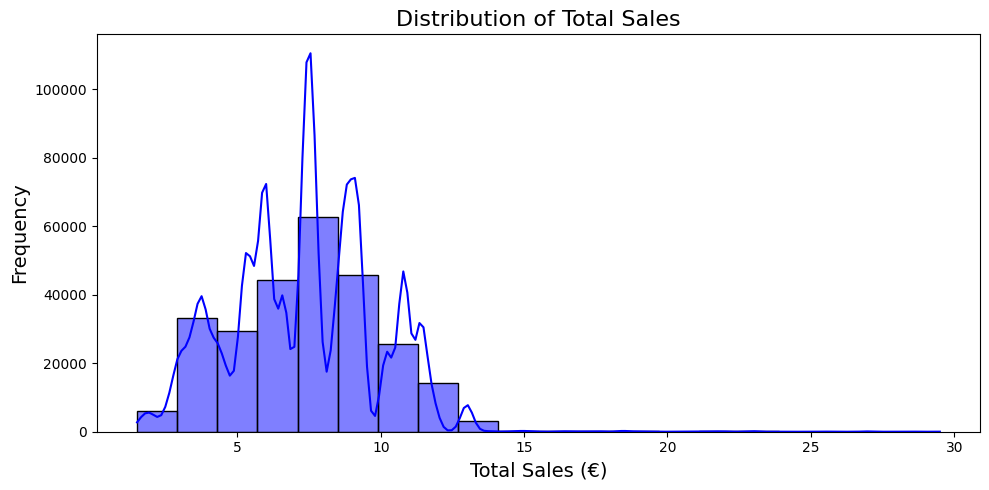

In [20]:
# Sales Distribution
# Histogram of sales
plt.figure(figsize=(10, 5))
sns.histplot(merged_data['TOT_SALES'], bins=20, kde=True, color='blue')
plt.title('Distribution of Total Sales', fontsize=16)
plt.xlabel('Total Sales (€)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.show()

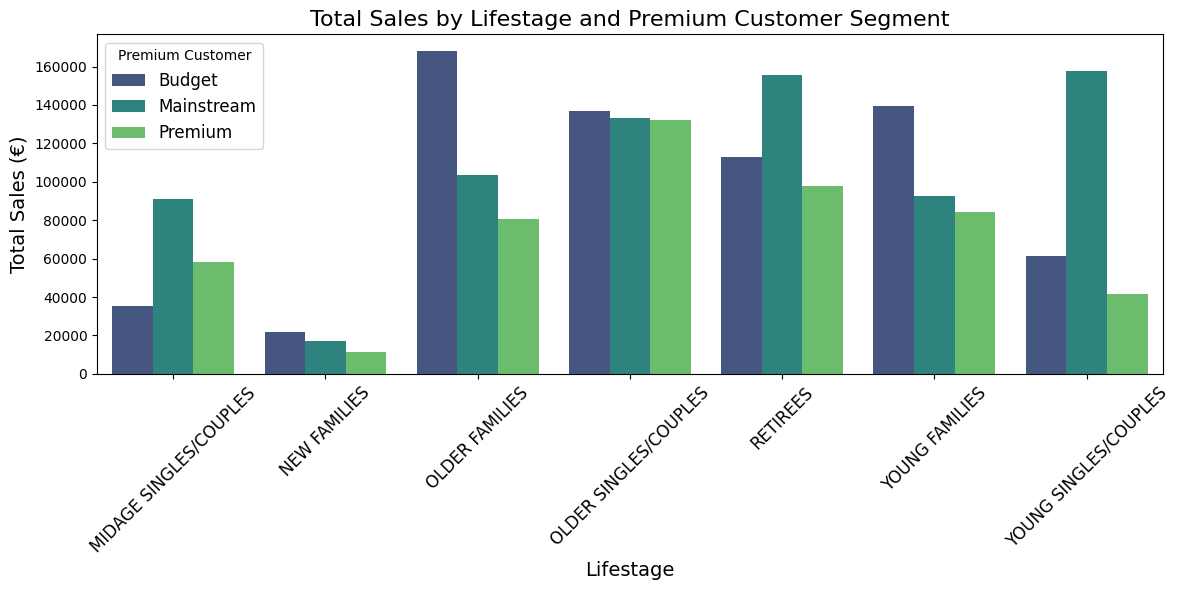

In [21]:
# Sales by Lifestage and Premium Segment
# Group sales by lifestage and premium customer segment
sales_by_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=sales_by_segment, x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER', palette='viridis')
plt.title('Total Sales by Lifestage and Premium Customer Segment', fontsize=16)
plt.xlabel('Lifestage', fontsize=14)
plt.ylabel('Total Sales (€)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Premium Customer', fontsize=12)
plt.tight_layout()
plt.show()


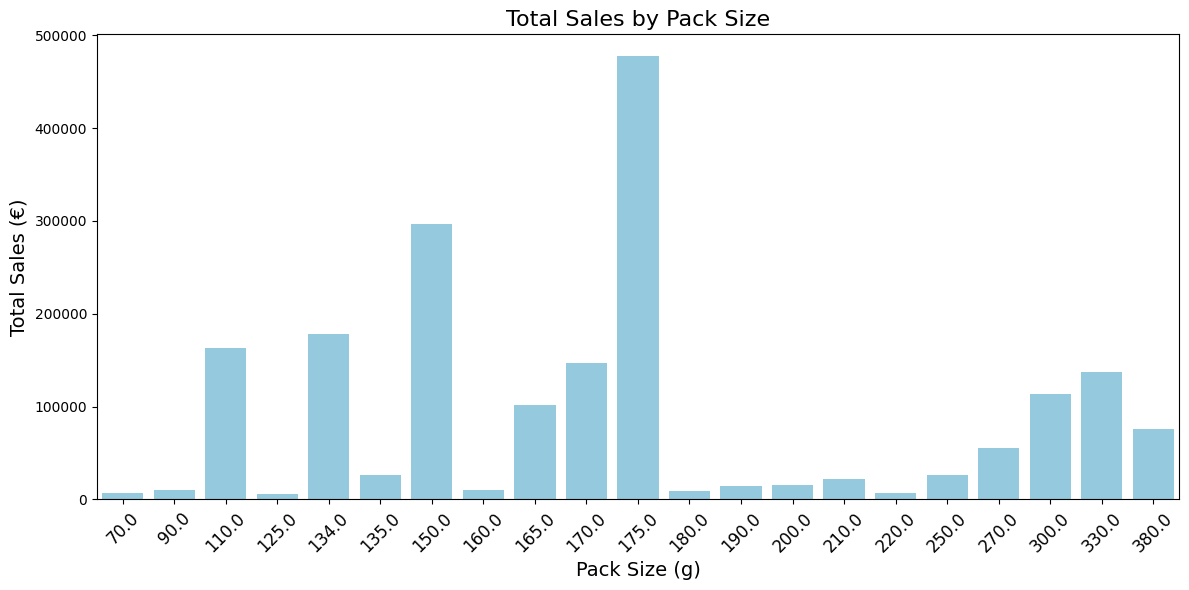

In [22]:
# Total Sales by Pack Size
# Group sales by pack size
pack_size_sales = merged_data.groupby('PACK_SIZE')['TOT_SALES'].sum().reset_index()

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=pack_size_sales, x='PACK_SIZE', y='TOT_SALES', color='skyblue')
plt.title('Total Sales by Pack Size', fontsize=16)
plt.xlabel('Pack Size (g)', fontsize=14)
plt.ylabel('Total Sales (€)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()


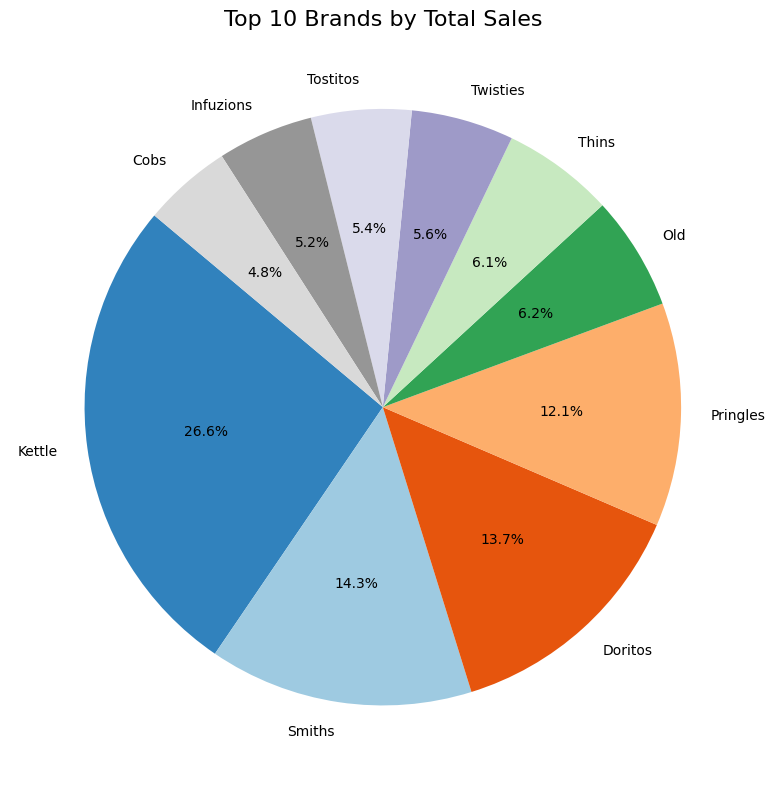

In [23]:
#  Top 10 Brands by Total Sales
# Group sales by brand and get top 10
brand_sales = merged_data.groupby('BRAND')['TOT_SALES'].sum().sort_values(ascending=False).head(10)

# Create a pie chart
plt.figure(figsize=(8, 8))
brand_sales.plot(kind='pie', autopct='%1.1f%%', startangle=140, colormap='tab20c')
plt.title('Top 10 Brands by Total Sales', fontsize=16)
plt.ylabel('')  # Remove default ylabel
plt.tight_layout()
plt.show()


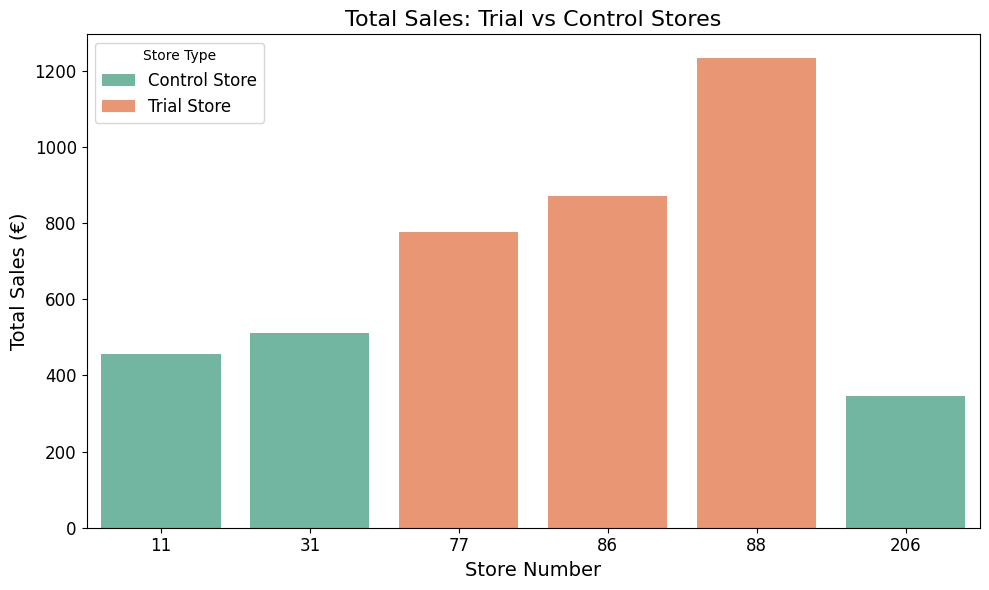

In [26]:
# Trial vs Control Store Sales
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example aggregated trial and control store data
trial_control_sales = pd.DataFrame({
    'STORE_TYPE': ['Trial Store', 'Trial Store', 'Trial Store', 'Control Store', 'Control Store', 'Control Store'],
    'STORE_NBR': [77, 86, 88, 11, 31, 206],
    'TOTAL_SALES': [777, 872, 1234, 456, 512, 345]  # Example sales data
})

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=trial_control_sales, x='STORE_NBR', y='TOTAL_SALES', hue='STORE_TYPE', palette='Set2')
plt.title('Total Sales: Trial vs Control Stores', fontsize=16)
plt.xlabel('Store Number', fontsize=14)
plt.ylabel('Total Sales (€)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Store Type', fontsize=12)
plt.tight_layout()
plt.show()



C:\Users\ashwi\AppData\Local\Temp\ipykernel_13844\823681851.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=correlation_df, x='Store Pair', y='Correlation', palette='pastel')


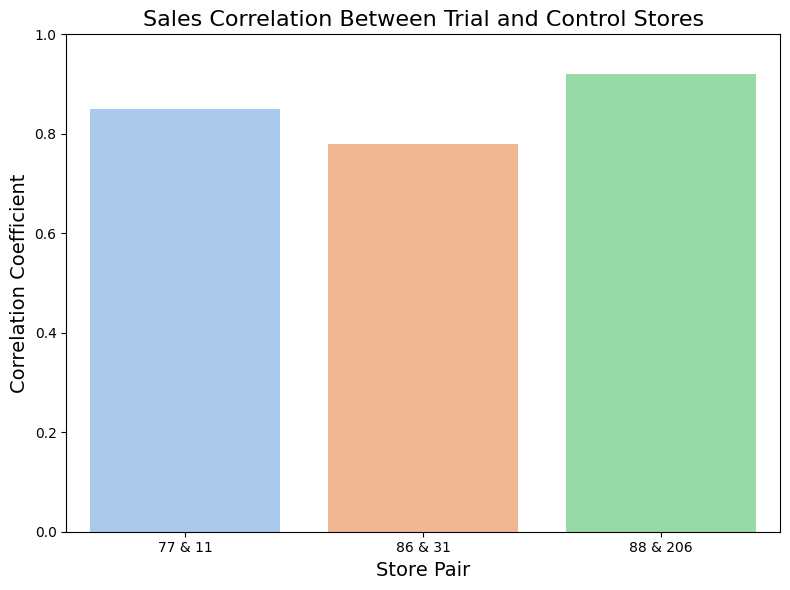

In [27]:
# Correlation Between Trial and Control Stores
# Example correlation data for trial and control stores
correlation_data = {
    'Store Pair': ['77 & 11', '86 & 31', '88 & 206'],
    'Correlation': [0.85, 0.78, 0.92]  # Example values
}
correlation_df = pd.DataFrame(correlation_data)

# Bar chart for correlation
plt.figure(figsize=(8, 6))
sns.barplot(data=correlation_df, x='Store Pair', y='Correlation', palette='pastel')
plt.title('Sales Correlation Between Trial and Control Stores', fontsize=16)
plt.xlabel('Store Pair', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=14)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


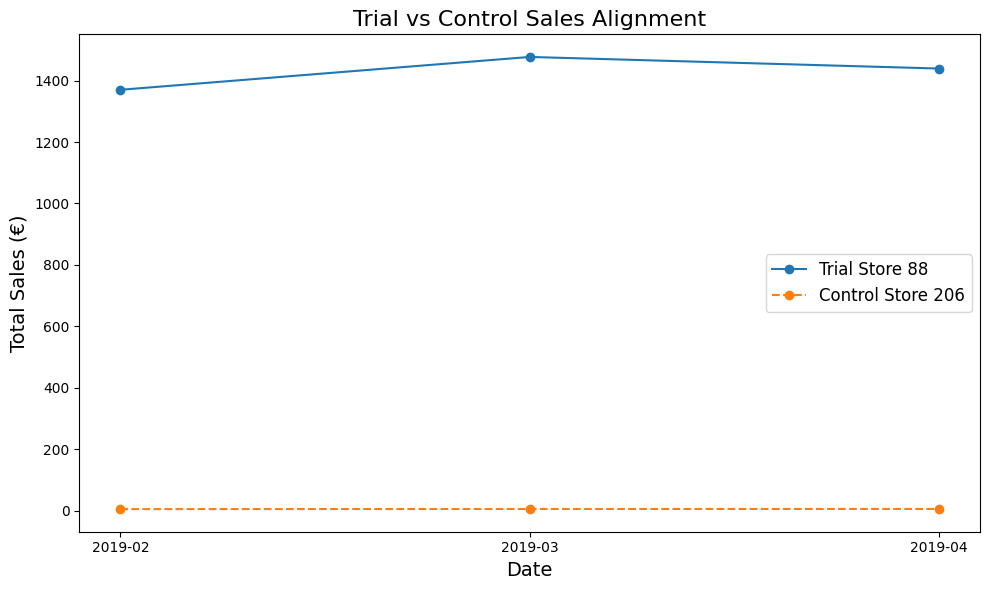

In [28]:
# Aligned Trial vs Control Sales
 # Example aligned sales data
aligned_data = {
    'Date': ['2019-02', '2019-03', '2019-04'],
    'Trial Store 88': [1370.2, 1477.2, 1439.4],
    'Control Store 206': [4.6, 5.0, 5.2]  # Example control sales
}
aligned_df = pd.DataFrame(aligned_data)

# Plot aligned sales
plt.figure(figsize=(10, 6))
plt.plot(aligned_df['Date'], aligned_df['Trial Store 88'], marker='o', label='Trial Store 88')
plt.plot(aligned_df['Date'], aligned_df['Control Store 206'], marker='o', linestyle='--', label='Control Store 206')
plt.title('Trial vs Control Sales Alignment', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales (€)', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
